##### Importing Required Libraries

In [5]:
import os
import pandas as pd
import dask.dataframe as dd

from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

### Data Exploration and Understanding

In [6]:
train_data = pd.read_csv(r'D:\Microsoft\Dataset\Train_Data.csv', nrows=10000)  # read a few rows to start

In [7]:
train_data['Category'].unique()

array(['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution',
       'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess',
       'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit',
       'PrivilegeEscalation', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware'], dtype=object)

In [8]:
train_data['EvidenceRole'].unique()

array(['Related', 'Impacted'], dtype=object)

In [9]:
train_data['CountryCode'].unique()

array([ 31, 242,   8,   7,  39,  12,  33,   2,  41,   3,   0,   1,   4,
        17,  23,  47,  42,  59,  46,  21,  16,   5,   9,  34,   6,  11,
        62,  57,  14,  37,  13,  29,  15,  32,  26,  19,  25,  51,  50,
        60,  67,  24,  65,  38,  43,  20,  75,  27, 140,  18,  58,  10,
        35,  64,  40,  70,  30,  36,  55,  45,  63,  52,  44,  22,  28,
        61,  68,  89], dtype=int64)

In [10]:
train_data.iloc[:,:15].head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,NaN,NaN,User,Impacted,98799
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,NaN,NaN,Url,Related,98799
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Url,Related,98799
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,NaN,NaN,User,Impacted,98799


In [11]:
train_data.iloc[:, [0, 9] + list(range(15, 30))].head()

,Id,IncidentGrade,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName
0,180388628218,TruePositive,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421
1,455266534868,FalsePositive,138268,360606,160396,22406,23032,22795,24887,153085,529644,NaN,1631,635,860,2251,3421
2,1056561957389,FalsePositive,138268,360606,68652,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421
3,1279900258736,BenignPositive,138268,360606,13,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421
4,214748368522,TruePositive,138268,360606,160396,449,592,440,479,153085,529644,NaN,1631,635,860,2251,3421


In [12]:
train_data.iloc[:, [0, 9] + list(range(30, 45))].head()

,Id,IncidentGrade,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,TruePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,FalsePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,FalsePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,BenignPositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,TruePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [13]:
# Count summary of Incident Grade classes
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4391
TruePositive      3446
FalsePositive     2110
Name: count, dtype: int64

In [14]:
# Percentage count summary of Incident Grade classes
train_data['IncidentGrade'].value_counts() * 100 / train_data['IncidentGrade'].shape[0]

IncidentGrade
BenignPositive    43.91
TruePositive      34.46
FalsePositive     21.10
Name: count, dtype: float64

In [15]:
train_data.isnull().sum()

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques       5799
IncidentGrade           53
ActionGrouped         9941
ActionGranular        9941
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
EmailClusterId        9881
RegistryKey              0
RegistryValueName        0
RegistryValueData        0
ApplicationId            0
ApplicationName          0
OAuthApplicationId       0
ThreatFamily          9923
FileName                 0
FolderPath               0
ResourceIdName           0
ResourceType          9992
Roles                 9789
O

### Data Preparation

In [16]:
# def prepare_data():
le_cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
                  'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily','CountryCode',
                  'OSFamily', 'OSVersion','State', 'City', 'RegistryValueName', 'RegistryValueData', 
                  'ResourceIdName', 'RegistryKey', 'OAuthApplicationId', 'ApplicationId', 'ApplicationName']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'FileName', 'FolderPath']

le_cat_columns += numerical_columns

numerical_columns = []

ohe_cat_columns = []

In [17]:
train_data[le_cat_columns].nunique().sort_values(ascending=False)

AccountUpn            3386
AccountName           2323
AccountSid            2211
AccountObjectId       2200
IpAddress             1879
NetworkMessageId      1193
FileName               706
DeviceName             686
Url                    603
Sha256                 512
FolderPath             465
DeviceId               375
City                   196
State                  136
EmailClusterId         114
CountryCode             68
ThreatFamily            59
ApplicationName         23
ApplicationId           21
EntityType              20
Category                17
ResourceIdName          12
RegistryKey             10
OSVersion                6
Roles                    6
RegistryValueName        5
ResourceType             5
RegistryValueData        4
OAuthApplicationId       3
OSFamily                 3
LastVerdict              3
AntispamDirection        2
SuspicionLevel           2
EvidenceRole             2
dtype: int64

In [18]:
train_data[numerical_columns].nunique().sort_values(ascending=False)

Series([], dtype: float64)

In [19]:
# Inspect columns with number of unique values less than 10
for col in train_data:
    if train_data[col].nunique() < 10:
        print(col, train_data[col].unique())

IncidentGrade ['TruePositive' 'FalsePositive' 'BenignPositive' nan]
ActionGrouped [nan 'ContainAccount' 'IsolateDevice']
ActionGranular [nan 'account password changed'
 'update stsrefreshtokenvalidfrom timestamp.' 'account disabled'
 'disable account.' 'isolateresponse' 'reset user password.'
 'change user password.' 'quarantinefile'
 'msecidentitiesconfirmusercompromised']
EvidenceRole ['Related' 'Impacted']
RegistryValueName [635   0  28  10  89]
RegistryValueData [860  25  94   0]
OAuthApplicationId [881   2   0]
ResourceType [nan 'Virtual Machine' 'API Management Service' 'Networking'
 'Azure Resource' 'Azure Arc machine']
Roles [nan 'Contextual' 'Destination' 'Attacker' 'Compromised' 'Suspicious'
 'Source']
OSFamily [5 0 2]
OSVersion [66  0  1  3 16  4]
AntispamDirection [nan 'Inbound' 'Intraorg']
SuspicionLevel [nan 'Suspicious' 'Incriminated']
LastVerdict [nan 'Suspicious' 'Malicious' 'NoThreatsFound']


### Data Preprocessing

In [20]:
def preprocess_data(df, le_cat_columns):
    """
        This function preprocesses the dataset
    """
    
    # Converts columns with fewer than 20 unique values to ohe categorical columns
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Converts numerical to label encoded categorical columns
    for le_col in le_cat_columns:
        df[le_col] = df[le_col].astype('object')

    return df

In [21]:
train_data = preprocess_data(train_data, le_cat_columns)

In [22]:
print(train_data[le_cat_columns].nunique())
print(train_data[ohe_cat_columns].nunique())
print(train_data[numerical_columns].nunique())

Category                17
EntityType              20
EvidenceRole             2
SuspicionLevel           2
LastVerdict              3
ResourceType             5
Roles                    6
AntispamDirection        2
ThreatFamily            59
CountryCode             68
OSFamily                 3
OSVersion                6
State                  136
City                   196
RegistryValueName        5
RegistryValueData        4
ResourceIdName          12
RegistryKey             10
OAuthApplicationId       3
ApplicationId           21
ApplicationName         23
DeviceId               375
Sha256                 512
IpAddress             1879
Url                    603
AccountSid            2211
AccountUpn            3386
AccountObjectId       2200
AccountName           2323
DeviceName             686
NetworkMessageId      1193
EmailClusterId         114
FileName               706
FolderPath             465
dtype: int64
Series([], dtype: float64)
Series([], dtype: float64)


In [23]:
from sklearn.feature_selection import f_classif

cat_columns = ohe_cat_columns + le_cat_columns

# stats_data = pd.DataFrame()

for cat in cat_columns:
    # One-Hot Encode the categorical data
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Adjust for the FutureWarning
    X_encoded = onehot_encoder.fit_transform(train_data[[cat]])  # Use double brackets to pass a 2D array
    
    # ANOVA F-Statistic
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train_data['IncidentGrade'])  # Assuming IncidentGrade is categorical
    f_statistic, p_value = f_classif(X_encoded, y)
    
    print("*" * 20)
    print(f"Feature: {cat}")
    print(f"ANOVA F-Statistic: {f_statistic}")
    print(f"p-Value: {p_value}")

********************
Feature: Category
ANOVA F-Statistic: [  7.00254755  92.58639546   3.09948296   6.49285618   9.79556804
  11.838447   299.46458326   0.61664621   7.26672376 546.64932359
  10.88150204   7.96114589  17.81756912   1.70405179  10.34171089
  15.17589261   1.04381464]
p-Value: [1.05950479e-004 4.24174750e-059 2.56200184e-002 2.19538767e-004
 1.89503308e-006 9.76713575e-008 3.55756337e-186 6.04145409e-001
 7.25665378e-005 0.00000000e+000 3.92457716e-007 2.67683745e-005
 1.57225136e-011 1.63840000e-001 8.58899200e-007 7.50932599e-010
 3.71848977e-001]
********************
Feature: EntityType
ANOVA F-Statistic: [  1.2465377    2.15773925   4.56910177 276.71322975  61.30340991
  57.40804916   0.85163764  68.85139816  71.39049445   2.75570284
 109.33946921   4.88714971   0.64581447   2.49425806  24.32592096
   9.3422696    5.10165539   1.2465377   33.63333252  77.87348648]
p-Value: [2.91049643e-001 9.07954176e-002 3.34548278e-003 1.50364845e-172
 2.88396644e-039 8.69618565e-0

********************
Feature: City
ANOVA F-Statistic: [6.80645596e+01 1.46734544e+01 1.22993762e+01 3.24679163e+00
 4.66914820e+00 5.78943213e+00 4.66914820e+00 8.90824569e+00
 5.71839837e+00 5.90045209e+00 4.44505659e+00 6.35562515e+00
 5.71839837e+00 7.49700000e+00 3.90848121e+00 2.87039257e+00
 5.71839837e+00 3.17319500e+00 6.35562515e+00 3.17319500e+00
 4.06111760e+00 1.90281104e+00 1.74575412e+00 3.73906962e+00
 3.17319500e+00 4.06111760e+00 4.06111760e+00 6.33902119e-01
 1.26817236e+00 5.71839837e+00 6.33902119e-01 1.03320553e+00
 1.26817236e+00 3.17319500e+00 1.90281104e+00 6.33902119e-01
 1.33897731e+00 1.82198597e+00 2.53781848e+00 1.26817236e+00
 1.23850801e+00 1.23850801e+00 1.26817236e+00 3.17319500e+00
 6.33902119e-01 3.80894093e+00 3.80894093e+00 6.33902119e-01
 6.06864403e-01 2.53781848e+00 6.33902119e-01 1.26817236e+00
 1.90281104e+00 6.33902119e-01 1.02063729e-01 1.26817236e+00
 1.90281104e+00 1.90281104e+00 6.33902119e-01 1.63379356e+00
 6.33902119e-01 6.33902119e-01 

********************
Feature: DeviceId
ANOVA F-Statistic: [  2.13055039   3.41121387   1.27774758   1.70405179   0.63390212
   1.27774758   0.85163764   0.63390212   0.85163764   0.63390212
   0.42572182   0.63390212   0.42572182   0.42572182   0.63390212
   0.63390212   0.42572182   0.42572182   1.27774758   1.26817236
   0.42572182   0.42572182   0.63390212   0.63390212   0.63390212
   0.42572182   0.85163764   0.42572182   0.63390212   0.42572182
   1.2465377    0.63390212   1.2465377    1.2465377    1.2465377
   1.2465377    0.42572182   0.63390212   1.26817236   0.63390212
   1.2465377    0.42572182   0.42572182   1.26817236 129.97413333
   1.2465377    1.2465377    1.2465377    1.2465377    0.42572182
   1.2465377    0.42572182   1.2465377    0.42572182   1.2465377
   1.2465377    1.2465377    0.63390212   0.42572182   0.42572182
   0.42572182   1.2465377    1.2465377    0.42572182   0.42572182
   0.42572182   0.42572182   0.42572182   0.42572182   0.63390212
   1.2465377    0.42

********************
Feature: IpAddress
ANOVA F-Statistic: [ 8.53758526  4.44505659  6.35562515 ...  0.42572182  1.2465377
 69.08679564]
p-Value: [1.16701180e-05 3.98035332e-03 2.67009566e-04 ... 7.34566587e-01
 2.91049643e-01 3.25137683e-44]
********************
Feature: Url
ANOVA F-Statistic: [ 3.33009995  1.11608187  0.61664621  1.90281104  0.54281708  0.54281708
  2.55724351  0.50276228  1.2465377   0.96396294  0.10206373  0.81645141
  0.42572182  0.33460652  0.85163764  0.10206373  1.90281104  0.42572182
  0.42572182  0.85163764  0.63390212  0.85163764  1.26817236  1.26817236
  0.42572182  1.26817236  0.63390212  0.42572182  0.42572182  0.19652241
  1.27774758  2.53781848  1.26817236  1.27774758  0.42572182  0.63390212
  0.42572182  1.26817236  0.63390212  0.63390212  0.42572182  1.2465377
  1.26817236  0.42572182  0.63390212  1.70405179  0.42572182  2.49425806
  0.85163764  0.63390212  0.63390212  0.42572182  0.42572182  0.19652241
  0.63390212  1.35983337  0.85163764  0.85163764

********************
Feature: AccountSid
ANOVA F-Statistic: [ 5.97780745 13.77724059  3.41121387 ...  0.42572182  1.2465377
 71.87224316]
p-Value: [4.57259238e-04 5.79164043e-09 1.67171954e-02 ... 7.34566587e-01
 2.91049643e-01 5.53889004e-46]
********************
Feature: AccountUpn
ANOVA F-Statistic: [ 5.97780745  7.497      10.80644835 ...  0.42572182  0.42572182
 43.58093466]
p-Value: [4.57259238e-04 5.21523763e-05 4.37637109e-07 ... 7.34566587e-01
 7.34566587e-01 5.67894595e-28]
********************
Feature: AccountObjectId
ANOVA F-Statistic: [ 5.97780745 13.77724059  3.41121387 ...  0.42572182  0.42572182
 74.39043656]
p-Value: [4.57259238e-04 5.79164043e-09 1.67171954e-02 ... 7.34566587e-01
 7.34566587e-01 1.39781049e-47]
********************
Feature: AccountName
ANOVA F-Statistic: [ 5.97780745 13.77724059  3.41121387 ...  0.42572182  0.42572182
 62.63034156]
p-Value: [4.57259238e-04 5.79164043e-09 1.67171954e-02 ... 7.34566587e-01
 7.34566587e-01 4.12923887e-40]
***************

********************
Feature: NetworkMessageId
ANOVA F-Statistic: [  4.99325356   0.63390212   1.2465377  ...   0.42572182   0.42572182
 109.98703025]
p-Value: [1.84307623e-03 5.93074592e-01 2.91049643e-01 ... 7.34566587e-01
 7.34566587e-01 4.59712592e-70]
********************
Feature: EmailClusterId
ANOVA F-Statistic: [0.42572182 0.63390212 0.63390212 0.42572182 1.2465377  0.42572182
 0.42572182 0.42572182 1.2465377  1.2465377  0.42572182 1.2465377
 0.63390212 1.2465377  1.2465377  0.42572182 1.2465377  0.42572182
 0.42572182 0.42572182 0.63390212 0.42572182 0.42572182 1.2465377
 0.42572182 1.2465377  0.63390212 0.42572182 0.42572182 1.2465377
 0.63390212 1.2465377  0.63390212 0.63390212 0.42572182 0.63390212
 0.63390212 1.2465377  0.42572182 0.63390212 1.2465377  1.2465377
 0.42572182 1.2465377  1.2465377  0.42572182 0.42572182 0.42572182
 0.63390212 0.63390212 0.42572182 1.2465377  0.42572182 0.42572182
 0.42572182 0.63390212 0.63390212 0.42572182 0.42572182 0.42572182
 0.63390212 1

In [24]:
# Convert 'Timestamp' column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Id                  10000 non-null  int64              
 1   OrgId               10000 non-null  int64              
 2   IncidentId          10000 non-null  int64              
 3   AlertId             10000 non-null  int64              
 4   Timestamp           10000 non-null  datetime64[ns, UTC]
 5   DetectorId          10000 non-null  int64              
 6   AlertTitle          10000 non-null  int64              
 7   Category            10000 non-null  object             
 8   MitreTechniques     4201 non-null   object             
 9   IncidentGrade       9947 non-null   object             
 10  ActionGrouped       59 non-null     object             
 11  ActionGranular      59 non-null     object             
 12  EntityType          10000 non-nul

### Data Processing

In [25]:
def process_data():
    train_data = pd.read_csv(r'D:\Microsoft\Dataset\Train_Data.csv')
    test_data = pd.read_csv(r'D:\Microsoft\Dataset\Test_Data.csv')
    
    
    print(train_data.shape)
    
    # Drop rows with missing target variable 'IncidentGrade'
    train_data.dropna(subset=['IncidentGrade'], inplace=True)
    
    train_data = preprocess_data(train_data, le_cat_columns)
    test_data = preprocess_data(test_data, le_cat_columns)
    
    group_columns = ohe_cat_columns + numerical_columns + le_cat_columns
    
    # Drop duplicates based on the specified columns
    train_data = train_data.drop_duplicates(subset=group_columns)
    
    # Drop usage column as it is not present in train dataset
    test_data.drop(['Usage'], axis=1, inplace=True)
    
    print(train_data.shape)
    print(test_data.shape)
    
    #  One hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(train_data[ohe_cat_columns])

    train_data_ohe = csr_matrix(ohe.transform(train_data[ohe_cat_columns]))
    test_data_ohe = csr_matrix(ohe.transform(test_data[ohe_cat_columns]))

    # Fill NaNs for numerical columns
    train_data_numerical = csr_matrix(train_data[numerical_columns].fillna(-1).values)
    test_data_numerical = csr_matrix(test_data[numerical_columns].fillna(-1).values)
    
    # Feature label encoding
    feature_le = LabelEncoder()
    
    train_data_le = pd.DataFrame()
    test_data_le = pd.DataFrame()
    
    # Fit and transform the feature variables
    for le_col in le_cat_columns:
        # we want to stack train and test for label encoding of some cat variables
        feature_le.fit(pd.concat([train_data[le_col], test_data[le_col]]))
        train_data_le[le_col] = feature_le.transform(train_data[le_col])
        test_data_le[le_col] = feature_le.transform(test_data[le_col])
    
    train_data_le = csr_matrix(train_data_le)
    test_data_le = csr_matrix(test_data_le)
    
    X_train = hstack([train_data_ohe, train_data_le ,train_data_numerical])
    X_test = hstack([test_data_ohe, test_data_le, test_data_numerical])

    # Target label encoding
    target_le = LabelEncoder()
    
    # Fit and transform the target variable
    target_le.fit(train_data['IncidentGrade'])
    y_train = target_le.transform(train_data['IncidentGrade'])
    y_test = target_le.transform(test_data['IncidentGrade'])
    
    # Print out the label classes of the target variable
    """
        0: 'BenignPositive'
        1: 'FalsePositive'
        2: 'TruePositive'
    """
    print(f"Target Classes: {target_le.classes_}")
        
    return X_train, y_train, X_test, y_test
    
    
# get the data
X_train, y_train, X_test, y_test = process_data()

C:\Users\VRISHALI\AppData\Local\Temp\ipykernel_21432\165186387.py:3: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(r'D:\Microsoft\Dataset\Test_Data.csv')


(9516837, 45)
(2489784, 45)
(4147992, 45)
Target Classes: ['BenignPositive' 'FalsePositive' 'TruePositive']


### Data Splitting

In [26]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def predict(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Print accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    
    cm = confusion_matrix(y_test, y_pred)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                        display_labels = ['BenignPositive', 'FalsePositive', 'TruePositive'])

    cm_display.plot()
    plt.show()

    return y_pred

### Model Selection and Training
### Model Evaluation and Tuning
### Model Interpretation

C:\Users\VRISHALI\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.4698

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.87      0.60   1752940
           1       0.49      0.03      0.06    902698
           2       0.52      0.26      0.35   1492354

    accuracy                           0.47   4147992
   macro avg       0.49      0.39      0.34   4147992
weighted avg       0.49      0.47      0.39   4147992


Confusion Matrix:


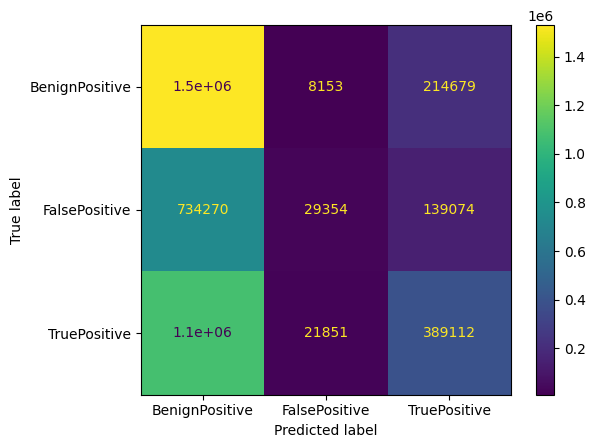

Baseline Model Cross-Validation Scores: [0.438  0.44   0.4395 0.439  0.44  ]
Mean Baseline CV Score: 0.43929999999999997


In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(random_state=0)
    model.fit(X_train, y_train)
    return model

baseline_model = train_logistic_regression(X_train, y_train)
y_pred_baseline = predict(baseline_model, X_test, y_test)
# Assuming X_encoded is your feature set and y is the target variable
baseline_model = LogisticRegression(max_iter=1000)

# Perform 5-fold cross-validation
cv_scores_baseline = cross_val_score(baseline_model, X_encoded, y, cv=5)

# Print cross-validation results for the baseline model
print(f"Baseline Model Cross-Validation Scores: {cv_scores_baseline}")
print(f"Mean Baseline CV Score: {cv_scores_baseline.mean()}")

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def train_random_forest_classifier(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.feature_importances_
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (Random Forest Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

# Create the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100)

# Perform 5-fold cross-validation
cv_scores_rf = cross_val_score(random_forest_model, X_encoded, y, cv=5)

# Print cross-validation results for the Random Forest model
print(f"Random Forest Cross-Validation Scores: {cv_scores_rf}")
print(f"Mean Random Forest CV Score: {cv_scores_rf.mean()}")

Random Forest Cross-Validation Scores: [0.4385 0.442  0.4415 0.441  0.442 ]
Mean Random Forest CV Score: 0.441


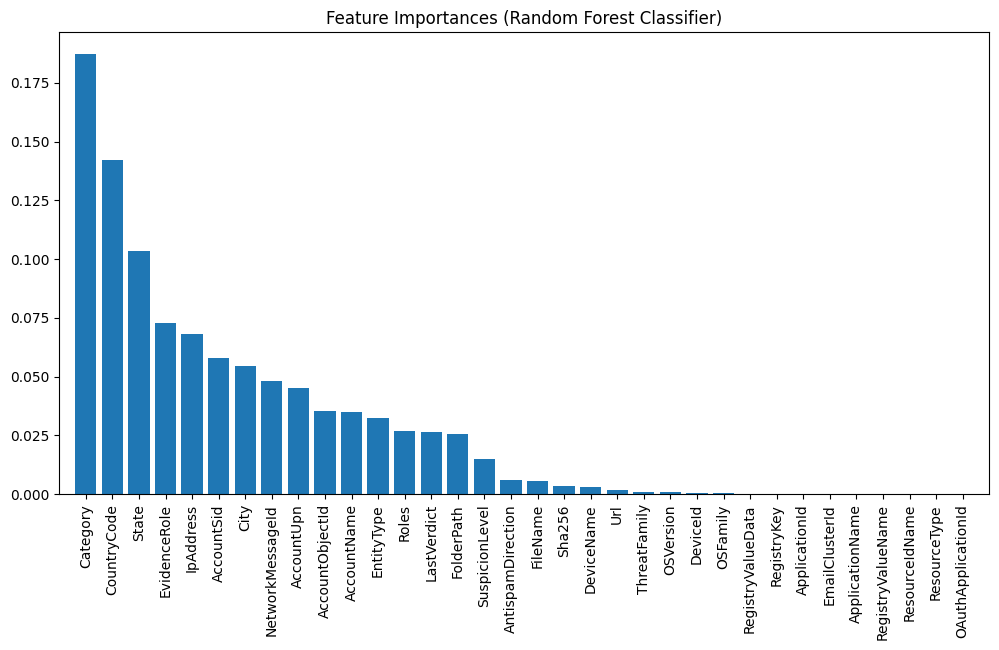

In [29]:
# train a random forest classifier model
rfc_model = train_random_forest_classifier(X_train, y_train)

Accuracy: 0.4987

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63   1752940
           1       0.64      0.06      0.10    902698
           2       0.94      0.18      0.31   1492354

    accuracy                           0.50   4147992
   macro avg       0.68      0.41      0.35   4147992
weighted avg       0.67      0.50      0.40   4147992


Confusion Matrix:


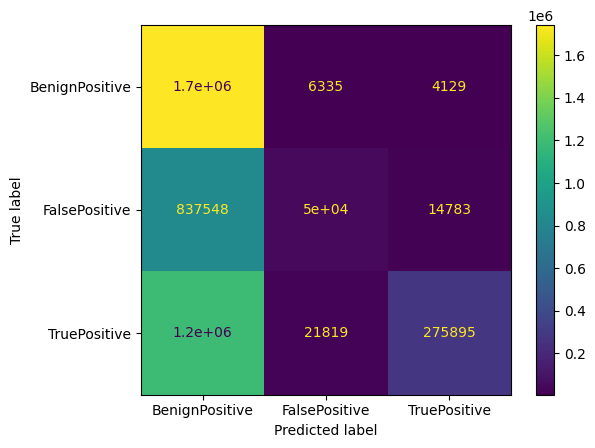

Accuracy: 0.49873239871243724
Macro-Precision: 0.6796399756953511
Macro-Recall: 0.4115663417201833
Macro-F1 Score: 0.3472925853310953


In [30]:
# make predictions
y_pred = predict(rfc_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

In [31]:
pip install xgboost

In [62]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from xgboost import XGBClassifier

def train_xgboost_classifier(X_train, y_train):
    model = XGBClassifier(n_estimators=100, max_depth=5, random_state=0, eval_metric='mlogloss')
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.feature_importances_
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (XGBoost Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

# Define the XGBoost model (removed 'use_label_encoder' to avoid warnings)
xgboost_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees (boosting rounds)
    max_depth=6,       # Maximum depth of each tree
    learning_rate=0.1, # Step size shrinkage
    objective='binary:logistic', # Use 'binary:logistic' for binary classification
    num_class=3,       # Number of classes for multi-class classification (update based on your data)
    eval_metric='logloss'    # Metric for multi-class classification
)

# Assuming X_encoded is your feature set and y is your target variable
# Perform k-fold cross-validation with 5 folds
cv_scores_xgboost = cross_val_score(
    xgboost_model, 
    X_encoded, 
    y, 
    cv=5,                # Number of folds (you can change to any k, e.g., 10 for 10-fold CV)
    scoring=make_scorer(accuracy_score)  # You can change this to another metric (e.g., F1 score)
)

# Output the cross-validation results
print(f"XGBoost Cross-Validation Scores: {cv_scores_xgboost}")
print(f"Mean XGBoost CV Score: {cv_scores_xgboost.mean()}")

XGBoost Cross-Validation Scores: [0.4385 0.44   0.4395 0.439  0.4385]
Mean XGBoost CV Score: 0.4391


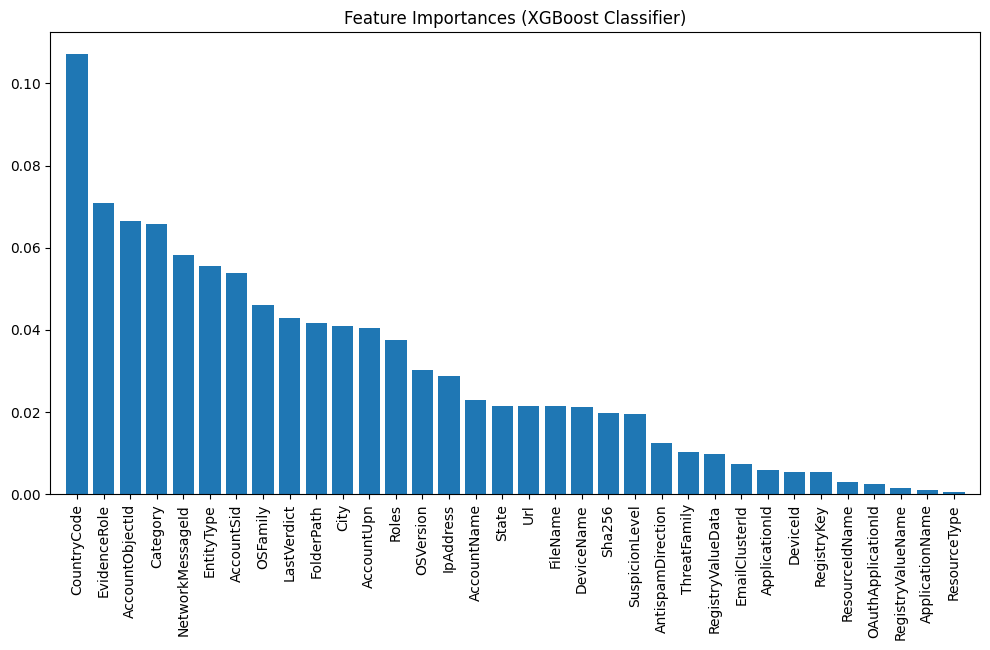

In [63]:
# train a random forest classifier model
xgboost_model = train_xgboost_classifier(X_train, y_train)

Accuracy: 0.6029

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.93      0.68   1752940
           1       0.77      0.26      0.39    902698
           2       0.83      0.42      0.56   1492354

    accuracy                           0.60   4147992
   macro avg       0.71      0.54      0.54   4147992
weighted avg       0.69      0.60      0.57   4147992


Confusion Matrix:


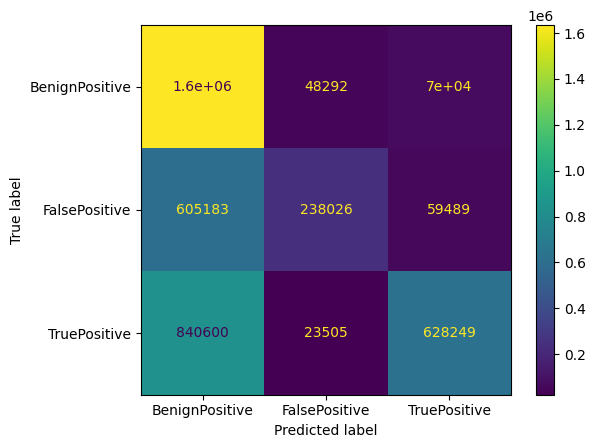

Accuracy: 0.6028707384199391
Macro-Precision: 0.7092523387645663
Macro-Recall: 0.5390179477047033
Macro-F1 Score: 0.5424400279719604


In [34]:
# make predictions
y_pred = predict(xgb_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

In [35]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [60]:
from catboost import CatBoostClassifier

def train_catboost_classifier(X_train, y_train):
    model = CatBoostClassifier(iterations=100, depth=5, random_seed=0, verbose=0)
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.get_feature_importance()
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (CatBoost Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

# Assuming categorical_features_index is already set up
catboost_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0)

# Perform 5-fold cross-validation
cv_scores_catboost = cross_val_score(catboost_model, X_encoded, y, cv=5)

# Print cross-validation results for CatBoost model
print(f"CatBoost Cross-Validation Scores: {cv_scores_catboost}")
print(f"Mean CatBoost CV Score: {cv_scores_catboost.mean()}")

CatBoost Cross-Validation Scores: [0.439  0.4395 0.439  0.439  0.439 ]
Mean CatBoost CV Score: 0.4391


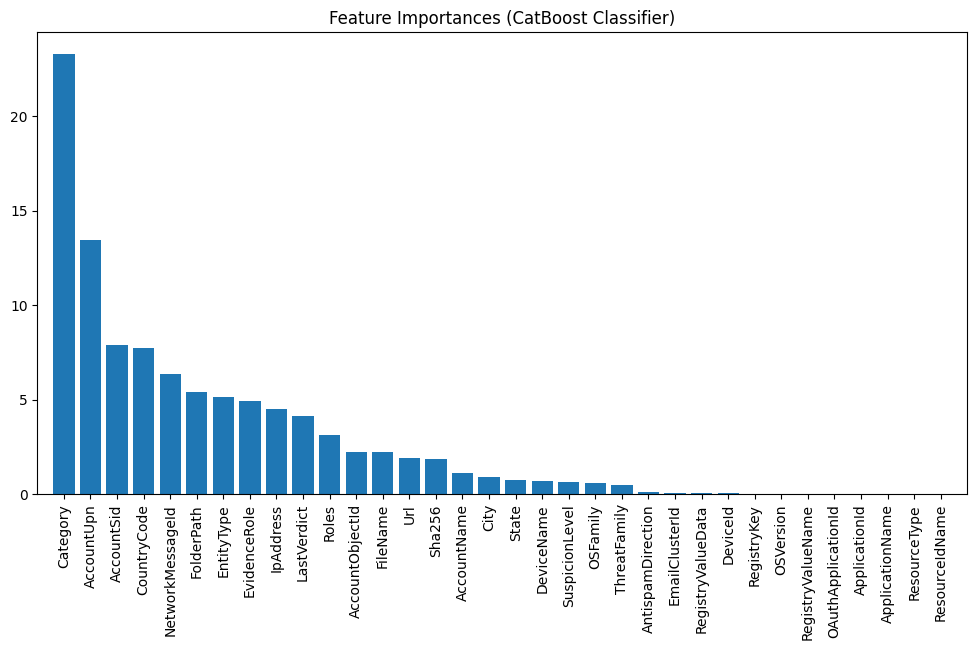

In [37]:
# train a random forest classifier model
cat_model = train_catboost_classifier(X_train, y_train)

### Final Evaluation on Test Set
#### Testing

Accuracy: 0.5881

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.87      0.66   1752940
           1       0.69      0.27      0.38    902698
           2       0.71      0.45      0.55   1492354

    accuracy                           0.59   4147992
   macro avg       0.65      0.53      0.53   4147992
weighted avg       0.63      0.59      0.56   4147992


Confusion Matrix:


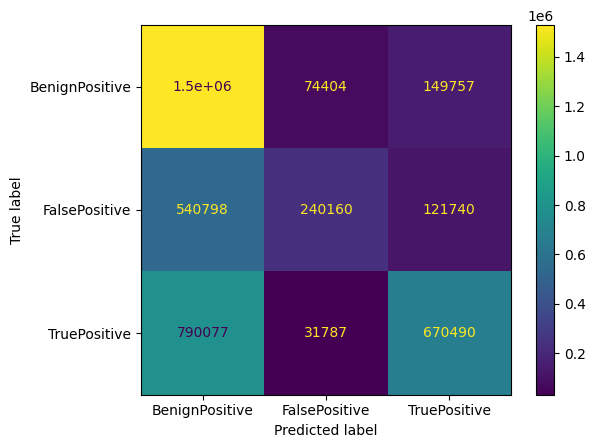

Accuracy: 0.5880987716466184
Macro-Precision: 0.6465953532230254
Macro-Recall: 0.5291510698704879
Macro-F1 Score: 0.5327599379596503


In [38]:
# make predictions
y_pred = predict(cat_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

#### Comparison to Baseline

C:\Users\VRISHALI\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.4335

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.99      0.62   1752940
           1       0.18      0.06      0.09    902698
           2       0.18      0.00      0.00   1492354

    accuracy                           0.43   4147992
   macro avg       0.27      0.35      0.24   4147992
weighted avg       0.29      0.43      0.28   4147992


Confusion Matrix:


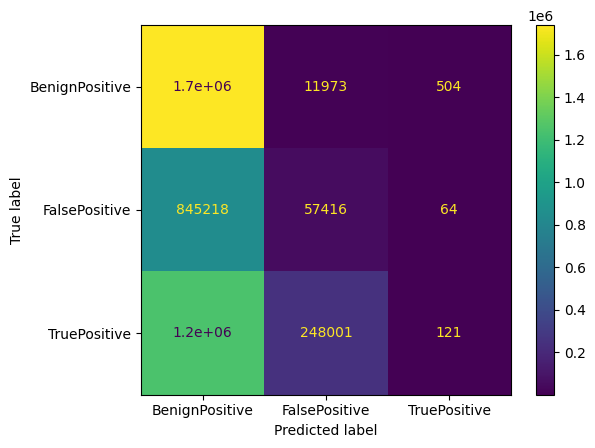

Baseline Model (Logistic Regression) Performance:
Accuracy: 0.43346274534762846
Macro-Precision: 0.2703188699813764
Macro-Recall: 0.35218940191878323
Macro-F1 Score: 0.23926098637832618


In [39]:
from sklearn.linear_model import LogisticRegression

def train_baseline_model(X_train, y_train):
    model = LogisticRegression(random_state=0, max_iter=1000)
    model.fit(X_train, y_train)
    return model

# Train the baseline logistic regression model
baseline_model = train_baseline_model(X_train, y_train)

# Make predictions using the baseline model
y_pred_baseline = predict(baseline_model, X_test, y_test)

# Evaluate test performance for the baseline model
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline, average='macro')
precision_baseline = precision_score(y_test, y_pred_baseline, average='macro')
f1_baseline = f1_score(y_test, y_pred_baseline, average='macro')

print('Baseline Model (Logistic Regression) Performance:')
print('Accuracy: {}'.format(accuracy_baseline))
print('Macro-Precision: {}'.format(precision_baseline))
print('Macro-Recall: {}'.format(recall_baseline))
print('Macro-F1 Score: {}'.format(f1_baseline))

Accuracy: 0.4987

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63   1752940
           1       0.64      0.06      0.10    902698
           2       0.94      0.18      0.31   1492354

    accuracy                           0.50   4147992
   macro avg       0.68      0.41      0.35   4147992
weighted avg       0.67      0.50      0.40   4147992


Confusion Matrix:


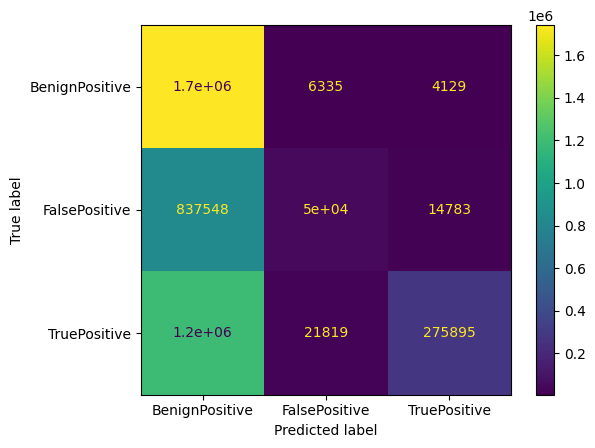

Random Forest Performance on Test Set:
Accuracy: 0.4987, Precision: 0.6796, Recall: 0.4116, F1 Score: 0.3473


In [40]:
# Predict with Random Forest on test set
y_pred_rf = predict(rfc_model, X_test, y_test)

# Evaluate Random Forest performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print('Random Forest Performance on Test Set:')
print(f'Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1 Score: {f1_rf:.4f}')

Accuracy: 0.4987

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63   1752940
           1       0.64      0.06      0.10    902698
           2       0.94      0.18      0.31   1492354

    accuracy                           0.50   4147992
   macro avg       0.68      0.41      0.35   4147992
weighted avg       0.67      0.50      0.40   4147992


Confusion Matrix:


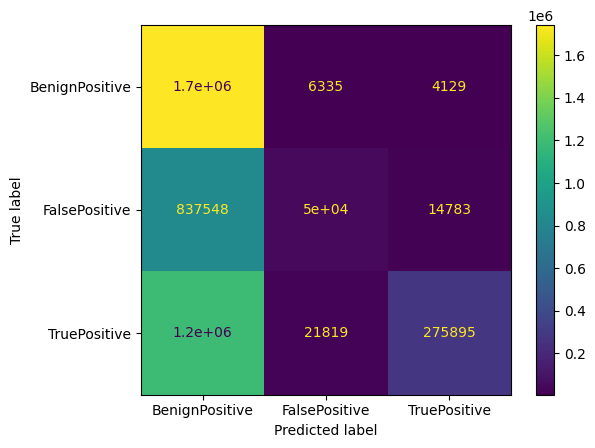

Random Forest Performance on Test Set:
Accuracy: 0.4987, Precision: 0.6796, Recall: 0.4116, F1 Score: 0.3473


In [41]:
# Predict with Random Forest on test set
y_pred_rf = predict(rfc_model, X_test, y_test)

# Evaluate Random Forest performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print('Random Forest Performance on Test Set:')
print(f'Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1 Score: {f1_rf:.4f}')

Accuracy: 0.6029

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.93      0.68   1752940
           1       0.77      0.26      0.39    902698
           2       0.83      0.42      0.56   1492354

    accuracy                           0.60   4147992
   macro avg       0.71      0.54      0.54   4147992
weighted avg       0.69      0.60      0.57   4147992


Confusion Matrix:


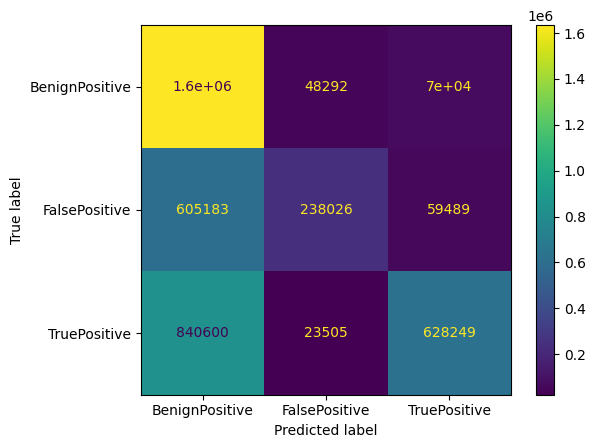

XGBoost Performance on Test Set:
Accuracy: 0.6029, Precision: 0.7093, Recall: 0.5390, F1 Score: 0.5424


In [42]:
# Predict with XGBoost on test set
y_pred_xgb = predict(xgb_model, X_test, y_test)

# Evaluate XGBoost performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb, average='macro')
precision_xgb = precision_score(y_test, y_pred_xgb, average='macro')
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

print('XGBoost Performance on Test Set:')
print(f'Accuracy: {accuracy_xgb:.4f}, Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}, F1 Score: {f1_xgb:.4f}')

Accuracy: 0.5881

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.87      0.66   1752940
           1       0.69      0.27      0.38    902698
           2       0.71      0.45      0.55   1492354

    accuracy                           0.59   4147992
   macro avg       0.65      0.53      0.53   4147992
weighted avg       0.63      0.59      0.56   4147992


Confusion Matrix:


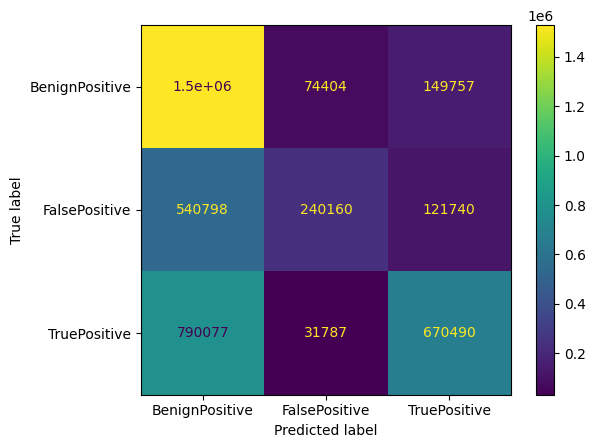

CatBoost Performance on Test Set:
Accuracy: 0.5881, Precision: 0.6466, Recall: 0.5292, F1 Score: 0.5328


In [43]:
# Predict with CatBoost on test set
y_pred_cat = predict(cat_model, X_test, y_test)

# Evaluate CatBoost performance
accuracy_cat = accuracy_score(y_test, y_pred_cat)
recall_cat = recall_score(y_test, y_pred_cat, average='macro')
precision_cat = precision_score(y_test, y_pred_cat, average='macro')
f1_cat = f1_score(y_test, y_pred_cat, average='macro')

print('CatBoost Performance on Test Set:')
print(f'Accuracy: {accuracy_cat:.4f}, Precision: {precision_cat:.4f}, Recall: {recall_cat:.4f}, F1 Score: {f1_cat:.4f}')

In [44]:
# Display comparison table
print(f"{'Model':<20}{'Accuracy':<15}{'Precision':<15}{'Recall':<15}{'F1 Score':<15}")
print("="*80)
print(f"{'Baseline (LogReg)':<20}{accuracy_baseline:<15.4f}{precision_baseline:<15.4f}{recall_baseline:<15.4f}{f1_baseline:<15.4f}")
print(f"{'Random Forest':<20}{accuracy_rf:<15.4f}{precision_rf:<15.4f}{recall_rf:<15.4f}{f1_rf:<15.4f}")
print(f"{'XGBoost':<20}{accuracy_xgb:<15.4f}{precision_xgb:<15.4f}{recall_xgb:<15.4f}{f1_xgb:<15.4f}")
print(f"{'CatBoost':<20}{accuracy_cat:<15.4f}{precision_cat:<15.4f}{recall_cat:<15.4f}{f1_cat:<15.4f}")

Model               Accuracy       Precision      Recall         F1 Score       
Baseline (LogReg)   0.4335         0.2703         0.3522         0.2393         
Random Forest       0.4987         0.6796         0.4116         0.3473         
XGBoost             0.6029         0.7093         0.5390         0.5424         
CatBoost            0.5881         0.6466         0.5292         0.5328         
